In [1]:
import json
import yaml

import numpy as np
import pylab as plt

from pathlib import Path
from utils import plot_conf
import os
import torch

In [2]:
model_names = ['resnet6', 'resnet10', 'resnet18']
queries = ['random', 'coreset', 'margin', 'badge', 'typiclust'] # ['random', 'coreset', 'margin', 'badge', 'typiclust']
train_methods = [('False', 'False'), ('True', 'False'), ('False', 'True'), ('True', 'True')]
seeds = ['1', '2', '3']
eval_model_names = ['resnet6', 'resnet10', 'resnet18'] # ['resnet6', 'resnet10', 'resnet18']
eval_train_methods = [('False', 'False'), ('True', 'False'), ('False', 'True'), ('True', 'True')] # [('False', 'False'), ('True', 'False'), ('False', 'True'), ('True', 'True')]

M = {'resnet6':'ResNet-6', 'resnet10':'ResNet-10', 'resnet18':'ResNet-18'}
T = {('False', 'False'):'Baseline', ('True', 'False'):'Semi-SL', ('False', 'True'):'Self-SL', ('True', 'True'):'SSSL'}
Q = {'random':'Random', 'coreset':'CoreSets', 'badge':'BADGE', 'margin':'Margin', 'typiclust':'TypiClust'}

Q_colors = {'random':'black', 'coreset':'orange', 'badge':'blue', 'margin':'red', 'typiclust':'green'}

dal_results = {mn:{
    q:{
        tm:{} for tm in train_methods
    } for q in queries
} for mn in model_names}
root_path = Path('/home/phahn/repositories/SDAL/notebooks/data/dal/')

count = 0

for mn in model_names:
    for q in queries:
        for tm in train_methods:
            us, up = tm
            paths = sorted(list(root_path.glob(mn+"/"+q+"/ssl_"+us+"/pre_"+up+"/*")))
            for path in paths:
                if os.path.exists(path / 'results.json'):
                    count += 1
                    with open(path / 'results.json', 'r') as f:
                        run_results = json.load(f)
                    with open(path / '.hydra/config.yaml') as g:
                        conf = yaml.load(g, Loader=yaml.FullLoader)

                    dal_results[mn][q][tm][path.stem[-1]] = {'results': run_results, 'args': conf}
print(f"Number of DAL Runs: {count}/180.")

reu_results = {
    mn:{
        q:{
            tm:{
                emn:{
                    etm:{} for etm in eval_train_methods
                } for emn in eval_model_names
            } for tm in train_methods
        } for q in queries
    } for mn in model_names
}
root_path = Path('/home/phahn/repositories/SDAL/notebooks/data/eval_reu/')

count = 0

for mn in model_names:
    for q in queries:
        for tm in train_methods:
            us, up = tm
            for emn in eval_model_names:
                for etm in eval_train_methods:
                    eus, eup = etm
                    paths = sorted(list(root_path.glob(mn+"/"+q+"/ssl_"+us+"/pre_"+up+"/eval_"+emn+"/eval_ssl_"+eus+"/eval_pre_"+eup+"/*")))
                    for path in paths:
                        if os.path.exists(path / 'results.json'):
                            count += 1
                            with open(path / 'results.json', 'r') as f:
                                run_results = json.load(f)

                            # Test acc
                            test_acc = run_results['eval_stats']['acc1']
                            reu_results[mn][q][tm][emn][etm][path.stem[-1]] = test_acc

print(f"Number of Reusability Runs: {count}/2160.")

Number of DAL Runs: 180/180.
Number of Reusability Runs: 2160/2160.


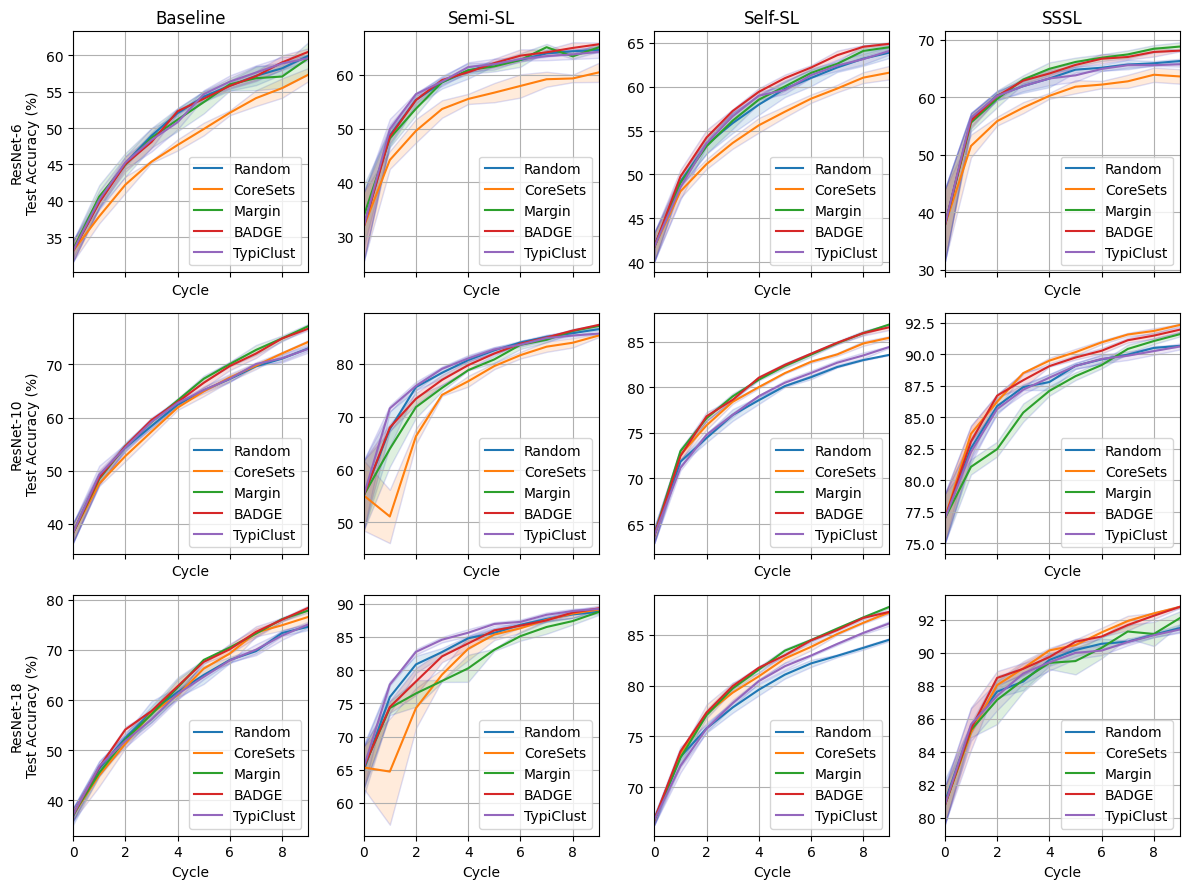

In [3]:
fig, axis = plt.subplots(nrows=len(model_names), ncols=len(train_methods), figsize=(3*len(train_methods), 3*len(model_names)), tight_layout=True, sharex=True)#, sharey=True)

for i, mn in enumerate(model_names):
    for q in queries:
        for l, tm in enumerate(train_methods):
            values = []
            for _, res in dal_results[mn][q][tm].items():
                values.append([h['test_stats']['acc1'] for h in res['results']])

            if len(values) > 0:
                mean = np.mean(values, axis=0)
                std = np.std(values, axis=0)

                axis[i][l].plot(mean, label=Q[q])
                axis[i][l].fill_between(
                    x=[j for j in range(len(mean))], 
                    y1=mean+std, 
                    y2=mean-std,
                    alpha=0.15,
                    edgecolor='#1B2ACC', 
                    )
                lgd = axis[i][l].legend(loc='lower right')
                axis[i][l].set_xlim(0, len(mean)-1)
                if i//2 == 1:
                    axis[i][l].set_xlabel('cycle')
                if i == 0:
                    axis[i][l].set_title(T[tm])
                if l == 0:
                    axis[i][l].set_ylabel(M[mn] + "\n" +"Test Accuracy (%)")
                axis[i][l].set_xlabel('Cycle')
                axis[i][l].grid(True)
plt.show()

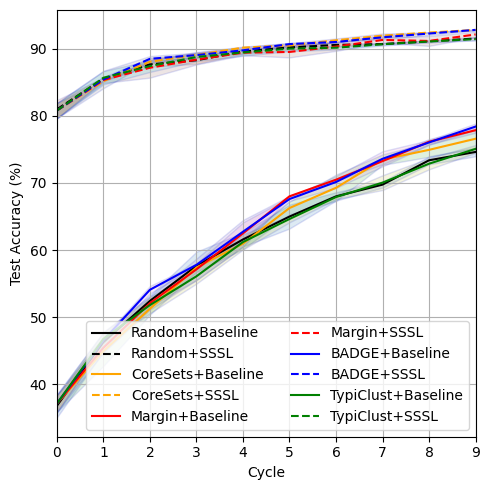

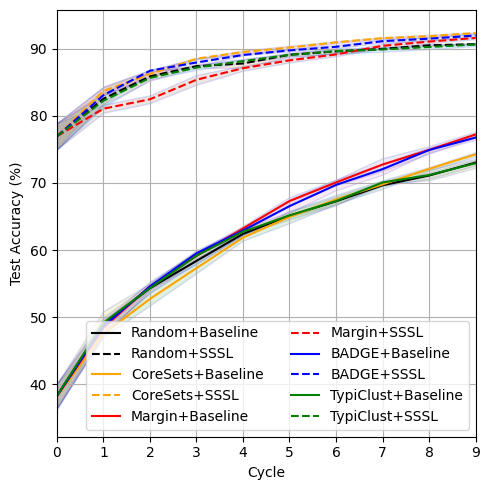

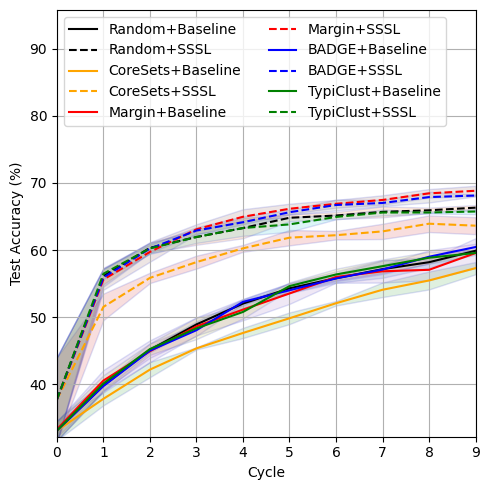

In [30]:
ylim = None

for mn in model_names[::-1]:
    plt.figure(figsize=(5,5), tight_layout=True)
    for q in queries:

        for tm in [train_methods[0]] + [train_methods[3]]:
            values = []
            for _, res in dal_results[mn][q][tm].items():
                values.append([h['test_stats']['acc1'] for h in res['results']])

            if len(values) == 0:
                print(mn, q)
            else:
                mean = np.mean(values, axis=0)
                std = np.std(values, axis=0)

                plt.plot(mean, c=Q_colors[q], linestyle='-' if tm == ('False', 'False') else '--', label=Q[q] + '+' + (T[tm]))
                plt.fill_between(
                    x=[j for j in range(len(mean))], 
                    y1=mean+std, 
                    y2=mean-std,
                    alpha=0.15,
                    edgecolor='#1B2ACC', 
                    )
    lgd = plt.legend(loc='upper left' if mn == 'resnet6' else 'lower right', ncol=2)
    plt.xlim(0, len(mean)-1)
    plt.grid(True)
    plt.xlabel('Cycle')
    plt.ylabel("Test Accuracy (%)")
    if ylim:
        plt.ylim(ylim)
    else:
        ylim = plt.ylim()
    plt.show()
    #plt.savefig('/home/phahn/repositories/SDAL/images/dal_results_'+ mn +'.pdf', bbox_inches='tight')

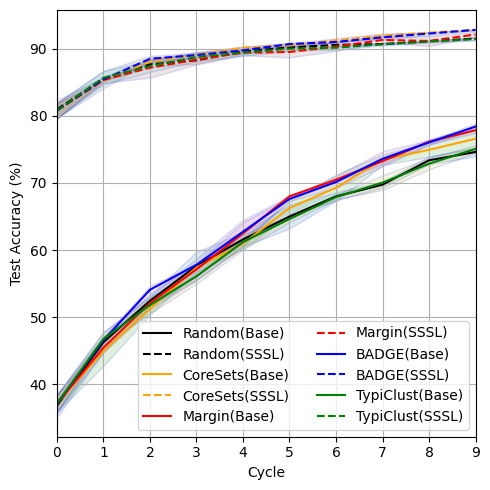

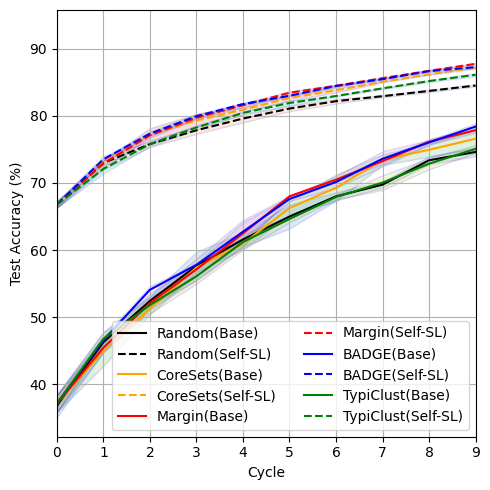

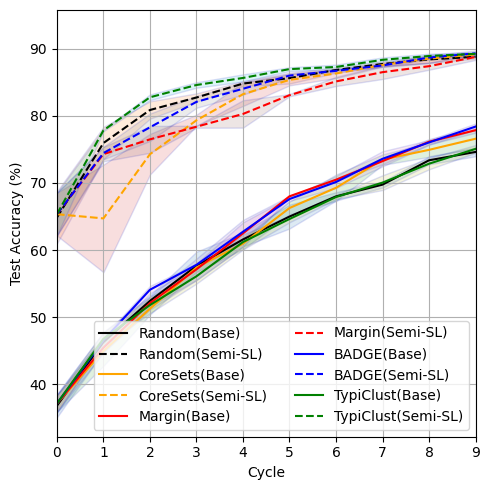

In [36]:
ylim = None
mn = 'resnet18'

for tm in train_methods[::-1]:
    if tm != ('False', 'False'):
        plt.figure(figsize=(5,5), tight_layout=True)
        for q in queries:
            for x in [False, True]:
                values = []
                if x:
                    for _, res in dal_results[mn][q][tm].items():
                        values.append([h['test_stats']['acc1'] for h in res['results']])
                else:
                    for _, res in dal_results[mn][q][train_methods[0]].items():
                        values.append([h['test_stats']['acc1'] for h in res['results']])

                mean = np.mean(values, axis=0)
                std = np.std(values, axis=0)

                plt.plot(mean, c=Q_colors[q], linestyle='-' if not x else '--', label=Q[q]+('(Base)' if not x else '('+T[tm]+')'))
                plt.fill_between(
                    x=[j for j in range(len(mean))], 
                    y1=mean+std, 
                    y2=mean-std,
                    alpha=0.15,
                    edgecolor='#1B2ACC', 
                    )
        lgd = plt.legend(loc='lower right', ncol=2)
        plt.xlim(0, len(mean)-1)
        plt.grid(True)
        plt.xlabel('Cycle')
        plt.ylabel("Test Accuracy (%)")
        if ylim:
            plt.ylim(ylim)
        else:
            ylim = plt.ylim()
        #plt.show()
        plt.savefig('/home/phahn/repositories/SDAL/images/dal_results_'+ T[tm] +'.pdf', bbox_inches='tight')

In [6]:
reusability = {
    mn:{
        q:{
            tm:{
                emn:{
                    etm:{} for etm in eval_train_methods
                } for emn in eval_model_names
            } for tm in train_methods
        } for q in queries
    } for mn in model_names
}

for mn in model_names:
    for q in queries:
        for tm in train_methods:
            for emn in eval_model_names:
                for etm in eval_train_methods:
                        for seed in seeds:
                            if seed in reu_results[mn][q][tm][emn][etm]:
                                reu = reu_results[mn][q][tm][emn][etm][seed] - dal_results[emn]['random'][etm][seed]['results'][-1]['test_stats']['acc1']
                                reusability[mn][q][tm][emn][etm][seed] = reu

In [23]:
setting, R, R_std, P, P_std = [], [], [], [], []

for mn in model_names:
    for q in queries:
        if q != 'random':
            for tm in train_methods:
                reu = []
                for emn in eval_model_names:
                    for etm in eval_train_methods:
                        for seed in seeds:
                            if seed in reu_results[mn][q][tm][emn][etm]:
                                reu.append(reusability[mn][q][tm][emn][etm][seed])
                setting.append((mn, q, tm))
                R.append(np.mean(reu))
                R_std.append(np.mean(reu))
                performances = [dal_results[mn][q][tm][seed]['results'][-1]['test_stats']['acc1'] for seed in seeds]
                P.append(np.mean(performances))
                P_std.append(np.std(performances))



indices = torch.topk(torch.tensor(R), k=9, largest=True)[1]
print('########################################################   Top 9 Settings for Reusability   ########################################################')
for i, idx in enumerate(indices):
    mn, q, tm = setting[idx]
    print(str(i+1)+'.', 'Model: ', M[mn], '\t', 'Query Strategy: ', Q[q], '\t',  'Training Method:', T[tm] + ('\t' if T[tm] == 'SSSL' else ''), '\t', 'Performance: ', round(P[idx],2), '+/-', round(P_std[idx],2), '\t', 'Reusability: ', round(R[idx],2), '+/-', round(R_std[idx],2))

print('\n\n\n')
print('########################################################   Worst 9 Settings for Reusability   ########################################################')
indices = torch.topk(torch.tensor(R), k=9, largest=False)[1]
for i, idx in enumerate(indices):
    mn, q, tm = setting[idx]
    print(str(i+1)+'.', 'Model: ', M[mn], '\t', 'Query Strategy: ', Q[q], '\t',  'Training Method:', T[tm] + ('\t' if T[tm] == 'SSSL' else ''), '\t', 'Performance: ', round(P[idx],2), '+/-', round(P_std[idx],2), '\t',  'Reusability: ', round(R[idx],2), '+/-', round(R_std[idx],2))

########################################################   Top 9 Settings for Reusability   ########################################################
1. Model:  ResNet-18 	 Query Strategy:  BADGE 	 Training Method: Baseline 	 Performance:  78.39 +/- 0.45 	 Reusability:  1.04 +/- 1.04
2. Model:  ResNet-10 	 Query Strategy:  Margin 	 Training Method: Baseline 	 Performance:  77.22 +/- 0.42 	 Reusability:  0.95 +/- 0.95
3. Model:  ResNet-6 	 Query Strategy:  BADGE 	 Training Method: Self-SL 	 Performance:  64.9 +/- 0.17 	 Reusability:  0.69 +/- 0.69
4. Model:  ResNet-6 	 Query Strategy:  BADGE 	 Training Method: Baseline 	 Performance:  60.46 +/- 0.49 	 Reusability:  0.64 +/- 0.64
5. Model:  ResNet-18 	 Query Strategy:  Margin 	 Training Method: Baseline 	 Performance:  77.85 +/- 0.38 	 Reusability:  0.58 +/- 0.58
6. Model:  ResNet-6 	 Query Strategy:  BADGE 	 Training Method: Semi-SL 	 Performance:  65.67 +/- 0.33 	 Reusability:  0.57 +/- 0.57
7. Model:  ResNet-10 	 Query Strategy:  BADGE

In [8]:
# There is a clear tendency towards too high performance does not enable good reusability
# Exceptions are CoreSets and ResNet-6, but we attribute their bad reusability to their bad performance overall, as the smaller ResNet-6 does not have
# a sufficiently rich feature space to to diversity based selection. Excluding the two ResNet-6 and CoreSet Runs, leaves us with the described view.

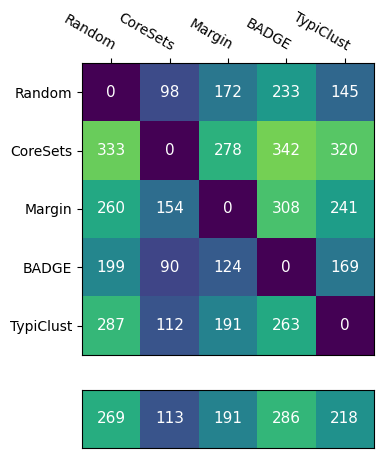

In [33]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(4, 5), gridspec_kw={'height_ratios':[len(queries), 1]})
axis = axis.reshape(-1 ,1)

confusion = []
labels = [Q[q] for q in queries]
for q1 in queries:
    c = []
    for q2 in queries:
        score = 0
        if q1 != q2:
            for mn in model_names:
                for tm in train_methods:
                    for seed in seeds:
                        for emn in eval_model_names:
                            for etm in eval_train_methods:
                                if seed in reu_results[mn][q1][tm][emn][etm] and seed in reu_results[mn][q2][tm][emn][etm]:
                                    score += int(reu_results[mn][q1][tm][emn][etm][seed] < reu_results[mn][q2][tm][emn][etm][seed])
        c.append(score)
    confusion.append(c)
# Number of comparisons are
# 3 Seeds * 3 Models * 4 Training Methods * 3 Eval Models * 4 Eval Training Methods
vmax = len(seeds) * len(model_names) * len(train_methods) * len(eval_model_names) * len(eval_train_methods)
plot_conf(conf=confusion, labels=labels, vmax=vmax, fig=fig, ax=axis)
#plt.show()
plt.savefig('/home/phahn/repositories/SDAL/images/reu_results_queries.pdf', bbox_inches='tight')

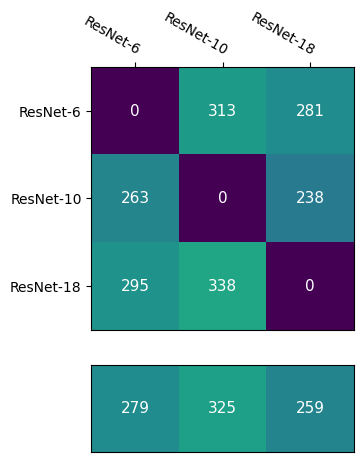

In [25]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(4, 5), gridspec_kw={'height_ratios':[len(model_names), 1]})
axis = axis.reshape(-1 ,1)

confusion = []
labels = [M[m] for m in model_names]
for m1 in model_names:
    c = []
    for m2 in model_names:
        score = 0
        if m1 != m2:
            for q in queries:
                if q != 'random':
                    for tm in train_methods:
                        for seed in seeds:
                            for emn in eval_model_names:
                                for etm in eval_train_methods:
                                    if seed in reu_results[m1][q][tm][emn][etm] and seed in reu_results[m2][q][tm][emn][etm]:
                                        score += int(reu_results[m1][q][tm][emn][etm][seed] < reu_results[m2][q][tm][emn][etm][seed])
        c.append(score)
    confusion.append(c)
# Number of comparisons are
# 3 Seeds * 4 Queries * 4 Training Methods * 3 Eval Models * 4 Eval Training Methods
vmax = len(seeds) * (len(queries)-1) * len(train_methods) * len(eval_model_names) * len(eval_train_methods)
plot_conf(conf=confusion, labels=labels, vmax=vmax, fig=fig, ax=axis)
#plt.show()
plt.savefig('/home/phahn/repositories/SDAL/images/reu_results_models.pdf', bbox_inches='tight')

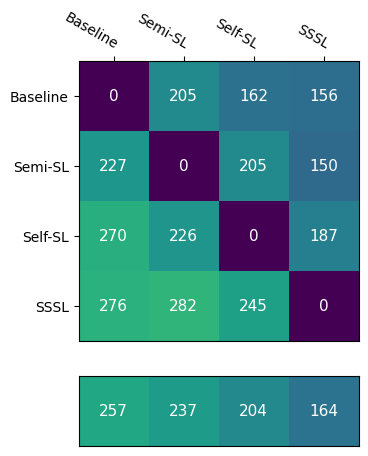

In [26]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(4, 5), gridspec_kw={'height_ratios':[len(train_methods), 1]})
axis = axis.reshape(-1 ,1)

confusion = []
labels = [T[tm] for tm in train_methods]
for tm1 in train_methods:
    c = []
    for tm2 in train_methods:
        score = 0
        if tm1 != tm2:
            for mn in model_names:
                for q in queries:
                    if q != 'random':
                        for seed in seeds:
                            for emn in eval_model_names:
                                for etm in eval_train_methods:
                                        if seed in reu_results[mn][q][tm1][emn][etm] and seed in reu_results[mn][q][tm2][emn][etm]:
                                            score += int(reu_results[mn][q][tm1][emn][etm][seed] < reu_results[mn][q][tm2][emn][etm][seed])
        c.append(score)
    confusion.append(c)
# Number of comparisons are
# 3 Seeds * 4 Queries * 3 Models * 3 Eval Models * 4 Eval Training Methods
vmax = len(seeds) * (len(queries)-1) * len(model_names) * len(eval_model_names) * len(eval_train_methods)
plot_conf(conf=confusion, labels=labels, vmax=vmax, fig=fig, ax=axis)
#plt.show()
plt.savefig('/home/phahn/repositories/SDAL/images/reu_results_training_methods.pdf', bbox_inches='tight')

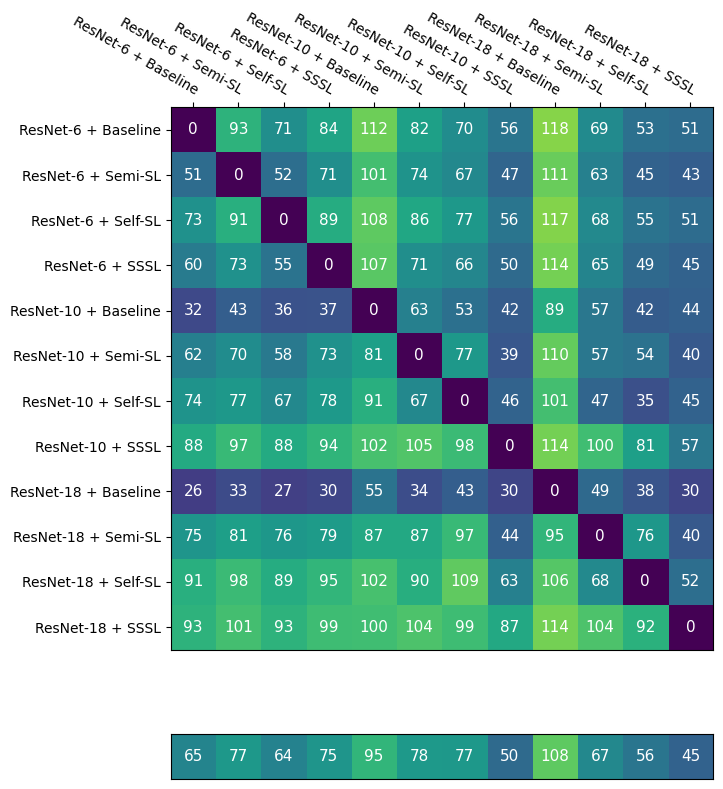

In [12]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(7, 9), gridspec_kw={'height_ratios':[len(model_names)*len(train_methods), 1]})
axis = axis.reshape(-1 ,1)

confusion = []
labels = [M[m]+' + '+T[tm] for m in model_names for tm in train_methods]
for m1 in model_names:
    for tm1 in train_methods:
        c = []
        for m2 in model_names:
            for tm2 in train_methods:
                score = 0
                if tm1 != tm2 or m1 != m2:
                    for q in queries:
                        if q != 'random':
                            for seed in seeds:
                                for emn in eval_model_names:
                                    for etm in eval_train_methods:
                                        if seed in reu_results[m1][q][tm1][emn][etm] and seed in reu_results[m2][q][tm2][emn][etm]:
                                            score += int(reu_results[m1][q][tm1][emn][etm][seed] < reu_results[m2][q][tm2][emn][etm][seed])
                c.append(score)
        confusion.append(c)
# Number of comparisons are
# 3 Seeds * 4 Queries * 3 Eval Models * 4 Eval Training Methods
vmax = len(seeds) * (len(queries)-1) * len(eval_model_names) * len(eval_train_methods)
plot_conf(conf=confusion, labels=labels, vmax=vmax, fig=fig, ax=axis)

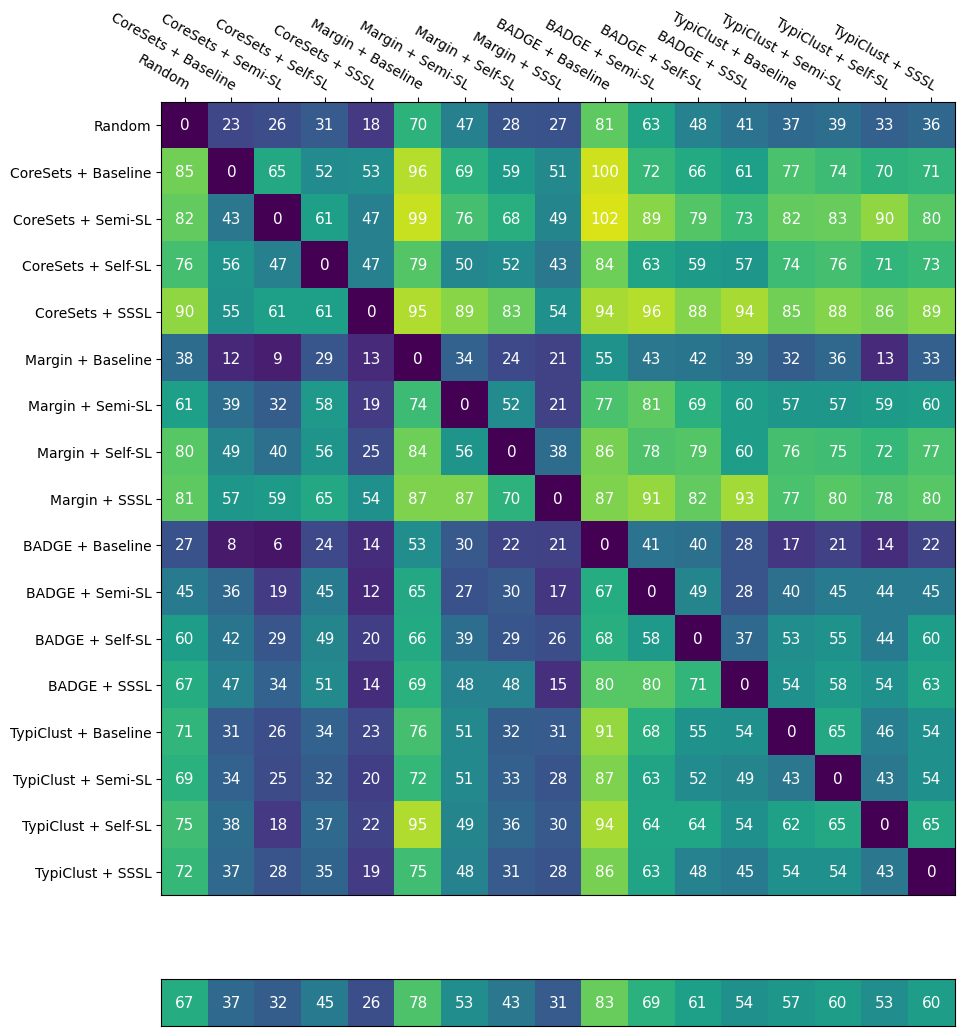

In [13]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(11, 12), gridspec_kw={'height_ratios':[1+(len(queries)-1)*len(train_methods), 1]})
axis = axis.reshape(-1 ,1)

confusion = []
labels =['Random'] + [Q[q]+' + '+T[tm] for q in queries for tm in train_methods if q != 'random']
for q1 in queries:
    for tm1 in train_methods:
        if q1 != 'random' or (T[tm1] == 'Baseline'):
            c = []
            for q2 in queries:
                for tm2 in train_methods:
                    if q2 != 'random' or (T[tm2] == 'Baseline'):
                        score = 0
                        for m in model_names:
                            for seed in seeds:
                                for emn in eval_model_names:
                                    for etm in eval_train_methods:
                                        if seed in reu_results[m][q1][tm1][emn][etm] and seed in reu_results[m][q2][tm2][emn][etm]:
                                            score += int(reu_results[m][q1][tm1][emn][etm][seed] < reu_results[m][q2][tm2][emn][etm][seed])
                        c.append(score)
            confusion.append(c)
# Number of comparisons are
# 3 Seeds * 3 Models * 3 Eval Models * 4 Eval Training Methods
vmax = len(seeds) * len(model_names) * len(eval_model_names) * len(eval_train_methods)
plot_conf(conf=confusion, labels=labels, vmax=vmax, fig=fig, ax=axis)

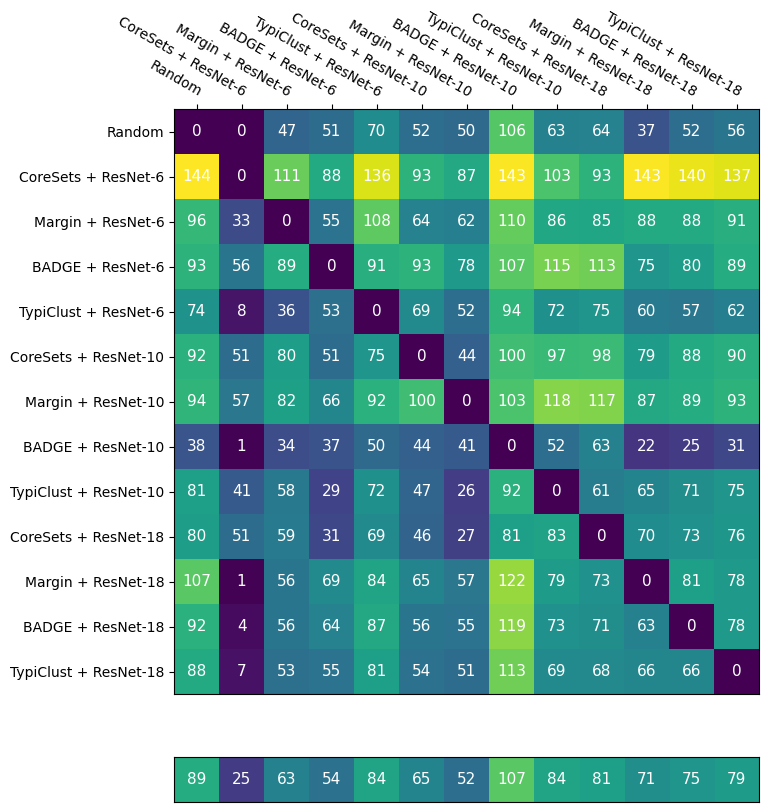

In [14]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(8, 9), gridspec_kw={'height_ratios':[1+(len(queries)-1)*len(model_names), 1]})
axis = axis.reshape(-1 ,1)

confusion = []
labels = ['Random'] + [Q[q]+' + '+M[m] for m in model_names for q in queries if q != 'random']
for q1 in queries:
    for m1 in model_names:
        if q1 != 'random' or m1 == model_names[0]:
            c = []
            for q2 in queries:
                for m2 in model_names:
                    if q2 != 'random' or m2 == model_names[0]:
                        score = 0
                        if q1 != q2 or m1 != m2:
                            for tm in train_methods:
                                for seed in seeds:
                                    for emn in eval_model_names:
                                        for etm in eval_train_methods:
                                            if seed in reu_results[m1][q1][tm][emn][etm] and seed in reu_results[m2][q2][tm][emn][etm]:
                                                score += int(reu_results[m1][q1][tm][emn][etm][seed] < reu_results[m2][q2][tm][emn][etm][seed])
                        c.append(score)
            confusion.append(c)
# Number of comparisons are
# 3 Seeds * 4 Training Methods * 3 Eval Models * 4 Eval Training Methods
vmax = len(seeds)* len(train_methods) * len(eval_model_names) * len(eval_train_methods)
plot_conf(conf=confusion, labels=labels, vmax=vmax, fig=fig, ax=axis)

In [15]:
# The more complex/advanced/specific the model is, the less reusable is their queried data. 
# Maximizing Model Performance throughout DAL may be suboptimal as it leads to very model specific querying of data.

In [16]:
# How do i want to present reusability? Check Math in Paper and think about it !